<a href="https://colab.research.google.com/github/UiinKim/UiinKim/blob/main/1D_CNN_%EC%8A%A4%ED%8C%B8_%EB%A9%94%EC%9D%BC_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")

('spam.csv', <http.client.HTTPMessage at 0x7ff45a2a0fd0>)

In [32]:
dataset=pd.read_csv('spam.csv', encoding='latin1')

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [34]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [35]:
data=dataset.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [36]:
data['v1'].replace(['spam', 'ham'],[1,0], inplace=True)
data['v1'].head()

0    0
1    0
2    1
3    0
4    0
Name: v1, dtype: int64

In [37]:
data['v2'].replace('[^a-zA-Z0-9]', '', inplace=True)
data['v2'].replace('', np.nan, inplace=True)
print(data.isnull().any())

v1    False
v2    False
dtype: bool


In [38]:
print(data.nunique())
print(len(data))


v1       2
v2    5169
dtype: int64
5572


In [39]:
data.drop_duplicates(subset=['v2'], inplace=True)
print(len(data))

5169


In [40]:
X_data=data['v2']
y_data=data['v1']

In [41]:
X_train,X_test, y_train, y_test=train_test_split(X_data,y_data, test_size=0.2, random_state=0, stratify=y_data)

In [42]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded=tokenizer.texts_to_sequences(X_train)

In [43]:
word_to_index=tokenizer.word_index

In [45]:
threshold=2
total_cnt=len(word_to_index)
total_freq=0
rare_cnt=0
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq+=value
  if value<threshold:
    rare_cnt+=1
    rare_freq+=value
print('유니크한 단어의 개수 비율 : ', rare_cnt/total_cnt*100)
print('유니크한 단어의 빈도 비율 : ', rare_freq/total_freq*100)

유니크한 단어의 개수 비율 :  55.45326684567191
유니크한 단어의 빈도 비율 :  6.65745644331875


In [46]:
tokenizer=Tokenizer(num_words=total_cnt-rare_cnt+1)
tokenizer.fit_on_texts(X_train)
X_train_encoded=tokenizer.texts_to_sequences(X_train)
X_test_encoded=tokenizer.texts_to_sequences(X_test)
vocab_size=total_cnt-rare_cnt+1

메일의 최대 길이 :  181
메일의 평균 길이 :  14.705683192261185


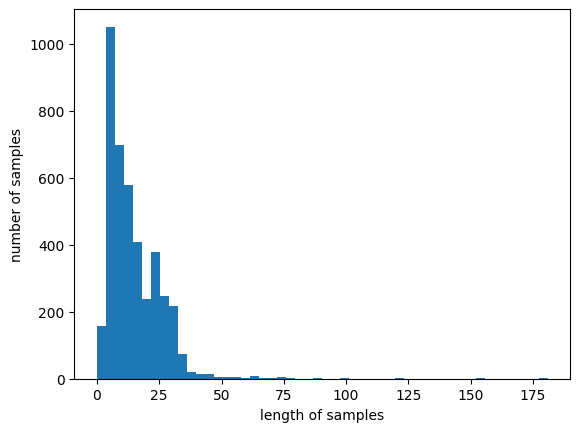

In [48]:
print('메일의 최대 길이 : ', max(len(word)for word in X_train_encoded))
print('메일의 평균 길이 : ', sum(map(len, X_train_encoded))/len(X_train_encoded))
plt.hist([len(sample) for sample in X_train_encoded], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [53]:
max_len=181
X_train_paded=pad_sequences(X_train_encoded, maxlen=max_len)

In [54]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
embedding_dim=32
dropout_ratio=0.3
kernel_size=5
num_filters=32
batch_size=64
epochs=10


model=Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history=model.fit(X_train_paded, y_train, batch_size, epochs, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
51/52 [============================>.] - ETA: 0s - loss: 0.4703 - acc: 0.8655
Epoch 1: val_acc improved from -inf to 0.87787, saving model to best_model.h5
52/52 [==============================] - 3s 37ms/step - loss: 0.4692 - acc: 0.8652 - val_loss: 0.3684 - val_acc: 0.8779
Epoch 2/10
51/52 [============================>.] - ETA: 0s - loss: 0.3656 - acc: 0.8722
Epoch 2: val_acc did not improve from 0.87787
52/52 [==============================] - 2s 31ms/step - loss: 0.3640 - acc: 0.8727 - val_loss: 0.3362 - val_acc: 0.8779
Epoch 3/10
51/52 [============================>.] - ETA: 0s - loss: 0.2790 - acc: 0.8894
Epoch 3: val_acc improved from 0.87787 to 0.96856, saving model to best_model.h5
52/52 [==============================] - 2s 47ms/step - loss: 0.2778 - acc: 0.8897 - val_loss: 0.2084 - val_acc: 0.9686
Epoch 4/10
50/52 [===========================>..] - ETA: 0s - loss: 0.1410 - acc: 0.9572
Epoch 4: val_acc improved from 0.96856 to 0.97823, saving model to best_model.h

In [50]:
X_test_paded=pad_sequences(X_test_encoded, maxlen=max_len)

In [56]:
print("\n 테스틑 정확도 : %.4f"%(model.evaluate(X_test_paded, y_test)[1]))

33/33 [==============================] - 0s 10ms/step - loss: 0.0696 - acc: 0.9826

 테스틑 정확도 : 0.9826
